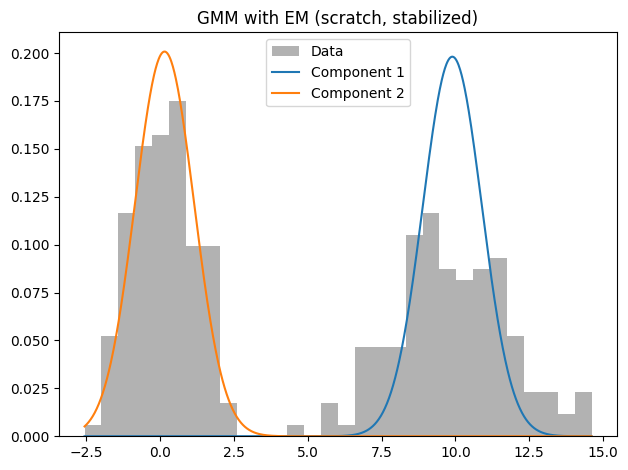

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. 가상 데이터 생성 (2개의 Gaussian 혼합)
np.random.seed(0)
data = np.concatenate([
    np.random.normal(0, 1, 150),
    np.random.normal(10, 2, 150)
])
n = len(data)
k = 2  # 군집 개수

# 2. 파라미터 초기화
pi = np.full(shape=k, fill_value=1/k)  # 혼합계수
mu = np.random.choice(data, k)         # 평균
sigma = np.full(shape=k, fill_value=1) # 분산
gamma = np.zeros((n, k))               # 책임도(responsibilities)

def e_step():
    global gamma, pi, mu, sigma
    """E-Step: 책임도 계산"""
    for i in range(k):
        gamma[:, i] = pi[i] * norm.pdf(data, mu[i], sigma[i] + 1e-6)
    gamma_sum = gamma.sum(axis=1, keepdims=True)
    gamma_sum[gamma_sum == 0] = 1e-10  # 방어적 처리
    gamma = gamma / gamma_sum
    return gamma

def m_step(gamma):
    global pi, mu, sigma
    """M-Step: 파라미터 업데이트"""
    Nk = gamma.sum(axis=0)
    for i in range(k):
        pi[i] = Nk[i] / n
        mu[i] = (gamma[:, i] @ data) / (Nk[i] + 1e-8)
        var_i = np.sum(gamma[:, i] * (data - mu[i]) ** 2) / (Nk[i] + 1e-8)
        sigma[i] = np.sqrt(np.maximum(var_i, 1e-3))  # 최소 분산 확보

# 3. 반복 학습
log_likelihoods = []

for iteration in range(100):
    gamma = e_step()
    m_step(gamma)

    # 로그 우도 계산
    likelihood = np.zeros((n,))
    for j in range(k):
        likelihood += pi[j] * norm.pdf(data, mu[j], sigma[j] + 1e-6)
    log_likelihood = np.sum(np.log(likelihood + 1e-10))
    log_likelihoods.append(log_likelihood)

    if iteration > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-4:
        break

# 4. 결과 시각화
x = np.linspace(min(data), max(data), 1000)
plt.hist(data, bins=30, density=True, alpha=0.6, color='gray', label="Data")
for i in range(k):
    plt.plot(x, pi[i] * norm.pdf(x, mu[i], sigma[i]), label=f'Component {i+1}')
plt.title("GMM with EM (scratch, stabilized)")
plt.legend()
plt.tight_layout()
plt.show()

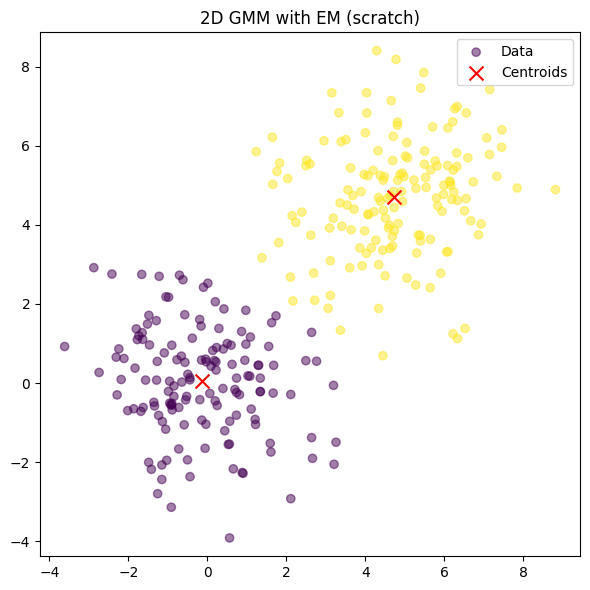

In [2]:
# 다차원 GMM용 EM 알고리즘 (2D 예시로 확장)
np.random.seed(0)

# 1. 데이터 생성 (2개의 2D Gaussian)
mean1 = [0, 0]
mean2 = [5, 5]
cov = [[2, 0], [0, 2]]

data1 = np.random.multivariate_normal(mean1, cov, 150)
data2 = np.random.multivariate_normal(mean2, cov, 150)
data = np.vstack((data1, data2))
n, d = data.shape
k = 2  # 군집 개수

# 2. 초기화
pi = np.full(shape=k, fill_value=1/k)                # 혼합계수
mu = data[np.random.choice(n, k, replace=False)]     # 평균 (k x d)
sigma = np.array([np.cov(data.T) for _ in range(k)]) # 공분산 행렬 (k x d x d)
gamma = np.zeros((n, k))                             # 책임도


# 수정된 multivariate_gaussian 함수 (브로드캐스팅 오류 해결)
def multivariate_gaussian(x, mean, cov):
    """다변량 정규분포 PDF 계산 (수정됨)"""
    d = x.shape[1]
    det = np.linalg.det(cov)
    norm_const = 1.0 / (np.power((2*np.pi), d/2) * np.sqrt(det + 1e-10))
    x_mu = x - mean
    inv = np.linalg.inv(cov + 1e-6 * np.eye(d))
    result = np.exp(-0.5 * np.sum(x_mu @ inv * x_mu, axis=1))
    return norm_const * result


def e_step():
    global gamma
    for i in range(k):
        gamma[:, i] = pi[i] * multivariate_gaussian(data, mu[i], sigma[i])
    gamma_sum = gamma.sum(axis=1, keepdims=True)
    gamma_sum[gamma_sum == 0] = 1e-10
    gamma = gamma / gamma_sum
    return gamma

def m_step(gamma):
    global pi, mu, sigma
    Nk = gamma.sum(axis=0)
    for i in range(k):
        pi[i] = Nk[i] / n
        mu[i] = (gamma[:, i][:, np.newaxis] * data).sum(axis=0) / (Nk[i] + 1e-8)
        x_mu = data - mu[i]
        sigma[i] = (gamma[:, i][:, np.newaxis, np.newaxis] * 
                    np.einsum('ni,nj->nij', x_mu, x_mu)).sum(axis=0) / (Nk[i] + 1e-8)
        sigma[i] += 1e-6 * np.eye(d)  # 수치 안정성

# 3. 반복 학습
log_likelihoods = []

for iteration in range(100):
    gamma = e_step()
    m_step(gamma)

    # 로그 우도 계산
    likelihood = np.zeros((n,))
    for j in range(k):
        likelihood += pi[j] * multivariate_gaussian(data, mu[j], sigma[j])
    log_likelihood = np.sum(np.log(likelihood + 1e-10))
    log_likelihoods.append(log_likelihood)

    if iteration > 1 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-4:
        break

# 4. 결과 시각화 (2D 산점도와 가우시안 중심 시각화)
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=gamma.argmax(axis=1), cmap='viridis', alpha=0.5, label='Data')
plt.scatter(mu[:, 0], mu[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("2D GMM with EM (scratch)")
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()
